<a href="https://colab.research.google.com/github/bttrung/CVND-udacity-facebook-scholarship/blob/master/5-cnn-layers/5_Fashion_MNIST_Training_Exercise%2C_solution_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

!git clone -l -s https://github.com/bttrung/CVND-udacity-facebook-scholarship.git
%cd cloned-repo
!ls

Cloning into 'CVND-udacity-facebook-scholarship'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 774 (delta 15), reused 0 (delta 0), pack-reused 746
Receiving objects: 100% (774/774), 131.52 MiB | 30.42 MiB/s, done.
Resolving deltas: 100% (144/144), done.
Checking out files: 100% (506/506), done.
[Errno 2] No such file or directory: 'cloned-repo'
/content
CVND-udacity-facebook-scholarship  sample_data


In [0]:
# our basic libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

In [3]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

data_path = 'CVND-udacity-facebook-scholarship/5-cnn-layers/data'

# choose the training and test datasets
train_data = FashionMNIST(root=data_path, train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root=data_path, train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

  0%|          | 16384/26421880 [00:00<02:54, 151324.82it/s]

26427392it [00:00, 77359361.59it/s]                            


Extracting CVND-udacity-facebook-scholarship/5-cnn-layers/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to CVND-udacity-facebook-scholarship/5-cnn-layers/data/FashionMNIST/raw


32768it [00:00, 480993.05it/s]
  5%|▍         | 212992/4422102 [00:00<00:02, 1885176.72it/s]

Extracting CVND-udacity-facebook-scholarship/5-cnn-layers/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to CVND-udacity-facebook-scholarship/5-cnn-layers/data/FashionMNIST/raw


4423680it [00:00, 22951374.93it/s]                           
0it [00:00, ?it/s]

Extracting CVND-udacity-facebook-scholarship/5-cnn-layers/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to CVND-udacity-facebook-scholarship/5-cnn-layers/data/FashionMNIST/raw


8192it [00:00, 125477.44it/s]


Extracting CVND-udacity-facebook-scholarship/5-cnn-layers/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to CVND-udacity-facebook-scholarship/5-cnn-layers/data/FashionMNIST/raw
Processing...
Done!
Train data, number of images:  60000
Test data, number of images:  10000


In [0]:
# prepare data loaders, set the batch_size
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

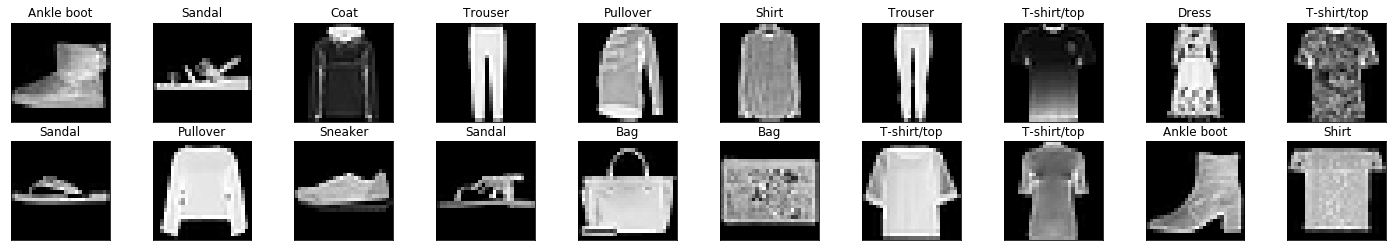

In [7]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

## Addding Dropout layer

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        ## output size = (W-F)/S +1 = (28-3)/1 +1 = 26
        # the output Tensor for one image, will have the dimensions: (10, 26, 26)
        # after one pool layer, this becomes (10, 13, 13)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(2, 2)
        
        # second conv layer: 10 inputs, 20 outputs, 3x3 conv
        ## output size = (W-F)/S +1 = (13-3)/1 +1 = 11
        # the output tensor will have dimensions: (20, 11, 11)
        # after another pool layer this becomes (20, 5, 5); 5.5 is rounded down
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        # 20 outputs * the 5*5 filtered/pooled map size
        self.fc1 = nn.Linear(20*5*5, 50)
        
        # dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)
        
        # finally, create 10 output channels (for the 10 classes)
        self.fc2 = nn.Linear(50, 10)

    # define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # prep for linear layer
        # this line of code is the equivalent of Flatten in Keras
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x

# instantiate and print your Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [0]:
import torch.optim as optim

## TODO: specify loss function
# using cross entropy whcih combines softmax and NLL loss
criterion = nn.CrossEntropyLoss()

## TODO: specify optimizer 
# stochastic gradient descent with a small learning rate AND some momentum
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
# to convert `correct` from a Tensor into a scalar, use .item()
accuracy = 100.0 * correct.item() / total

# print it out!
print('Accuracy before training: ', accuracy)

Accuracy before training:  12.29


### Train the Network

Below, we've defined a `train` function that takes in a number of epochs to train for. 
* The number of epochs is how many times a network will cycle through the entire training dataset. 
* Inside the epoch loop, we loop over the training dataset in batches; recording the loss every 1000 batches.

Here are the steps that this training function performs as it iterates over the training dataset:

1. Zero's the gradients to prepare for a forward pass
2. Passes the input through the network (forward pass)
3. Computes the loss (how far is the predicted classes are from the correct labels)
4. Propagates gradients back into the network’s parameters (backward pass)
5. Updates the weights (parameter update)
6. Prints out the calculated loss


In [0]:
def train(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [12]:
# define the number of epochs to train for
n_epochs = 30 # start small to see if your model works, initially

# call train
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 1.5886062551140785
Epoch: 1, Batch: 2000, Avg. Loss: 0.9027181954979897
Epoch: 1, Batch: 3000, Avg. Loss: 0.7921221467256546
Epoch: 2, Batch: 1000, Avg. Loss: 0.7227315821051598
Epoch: 2, Batch: 2000, Avg. Loss: 0.6878473876863718
Epoch: 2, Batch: 3000, Avg. Loss: 0.6618102329075336
Epoch: 3, Batch: 1000, Avg. Loss: 0.6264831718504429
Epoch: 3, Batch: 2000, Avg. Loss: 0.6008760548382998
Epoch: 3, Batch: 3000, Avg. Loss: 0.5848137874305248
Epoch: 4, Batch: 1000, Avg. Loss: 0.5724540710151196
Epoch: 4, Batch: 2000, Avg. Loss: 0.5601785968840122
Epoch: 4, Batch: 3000, Avg. Loss: 0.5502052016109228
Epoch: 5, Batch: 1000, Avg. Loss: 0.5386839891821146
Epoch: 5, Batch: 2000, Avg. Loss: 0.5252480185106396
Epoch: 5, Batch: 3000, Avg. Loss: 0.5210947518944741
Epoch: 6, Batch: 1000, Avg. Loss: 0.5018842022716999
Epoch: 6, Batch: 2000, Avg. Loss: 0.49925814355164766
Epoch: 6, Batch: 3000, Avg. Loss: 0.4992397274672985
Epoch: 7, Batch: 1000, Avg. Loss: 0.497540739

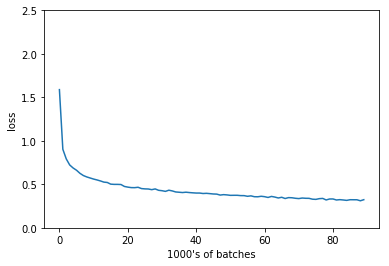

In [13]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

In [14]:
# Test the trained network
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.312660

Test Accuracy of T-shirt/top: 82% (824/1000)
Test Accuracy of Trouser: 97% (976/1000)
Test Accuracy of Pullover: 73% (738/1000)
Test Accuracy of Dress: 89% (899/1000)
Test Accuracy of  Coat: 89% (892/1000)
Test Accuracy of Sandal: 96% (960/1000)
Test Accuracy of Shirt: 67% (673/1000)
Test Accuracy of Sneaker: 98% (980/1000)
Test Accuracy of   Bag: 97% (975/1000)
Test Accuracy of Ankle boot: 93% (930/1000)

Test Accuracy (Overall): 88% (8847/10000)


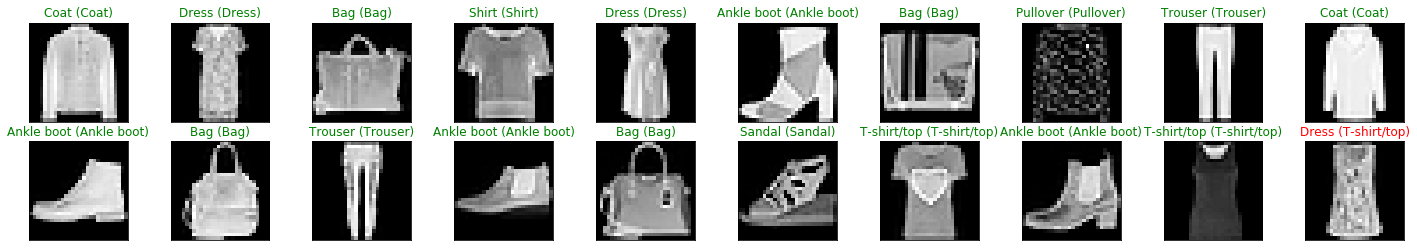

In [15]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### Question: What are some weaknesses of your model? (And how might you improve these in future iterations.)
**Answer**: Since t-shirts, shirts, and coats have a similar overall shape, my model has trouble distinguishing between those items. In fact, its lowest test class accuracy is: `Test Accuracy of Shirt`, which this model only gets right about 60% of the time . 

I suspect that this accuracy could be improved by doing some data augmentation with respect to these classes or even adding another convolutional layer to extract even higher level features.

In [0]:
# Saving the model
model_dir = './'
model_name = 'fashion_net_ex.pt'

# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
torch.save(net.state_dict(), model_dir+model_name)